In [3]:
import numpy as np
import pandas as pd
import math
from dateutil import parser

import sklearn as sk
import matplotlib.pyplot as plt
from obspy import Stream, Trace, UTCDateTime
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

import pylab as pl
from keras.callbacks import ModelCheckpoint

import datetime
import keras

from keras.layers import Activation, Conv1D, Dense, Dropout, Flatten, MaxPooling3D, BatchNormalization, InputLayer, LSTM
from keras.layers import Dropout
from keras.layers.advanced_activations import LeakyReLU
from keras.losses import categorical_crossentropy
from keras.models import Sequential
from keras.utils import Sequence
from keras.optimizers import Adam
from tensorflow.keras import regularizers
from keras.utils import np_utils
from keras.utils.vis_utils import plot_model
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import ParameterGrid
import re
from sklearn.metrics import confusion_matrix

import os
import sys
classes_dir = 'F:\Thesis_ssd\MasterThesis3.0'
os.chdir(classes_dir)
from Classes.DataProcessing.LoadData import LoadData
from Classes.DataProcessing.HelperFunctions import HelperFunctions
from Classes.DataProcessing.DataHandler import DataHandler
from Classes.DataProcessing.DataGenerator import DataGenerator
from Classes.DataProcessing.NoiseAugmentor import NoiseAugmentor
from Classes.Modeling.Models import Models
from Classes.Modeling.CustomCallback import CustomCallback
from Classes.Scaling.ScalerFitter import ScalerFitter
from Classes.Scaling.MinMaxScalerFitter import MinMaxScalerFitter
from Classes.Scaling.StandardScalerFitter import StandardScalerFitter
from Classes import Tf_shutup
Tf_shutup.Tf_shutup()

from livelossplot import PlotLossesKeras

import tensorflow as tf

from matplotlib.colors import ListedColormap
%matplotlib inline
plt.rcParams["figure.figsize"]= (15,15)
helper = HelperFunctions()

import sys
ISCOLAB = 'google.colab' in sys.modules

import random
import pprint

base_dir = 'F:\Thesis_ssd\MasterThesis3.0'
os.chdir(base_dir)

In [4]:
### Data conditions: ###
load_args = {
    'earth_explo_only' : True,
    'noise_earth_only' : False,
    'downsample' : True,
    'upsample' : True,
    'frac_diff' : 0.5,
    'seed' : 1,
    'subsample_size' : 0.05
}

loadData = LoadData(**load_args)

full_ds, train_ds, val_ds, test_ds = loadData.get_datasets()
noise_ds = loadData.noise_ds
handler = DataHandler(loadData)
data_gen = DataGenerator(loadData)
full_and_noise_ds = np.concatenate((full_ds, noise_ds))

In [ ]:
print(len(train_ds), len(val_ds), len(test_ds))
classes, counts = handler.get_class_distribution_from_ds(train_ds)
print("Nr noise samples " + str(len(loadData.noise_ds)))

In [ ]:
trace, info = handler.path_to_trace(train_ds[train_ds[:,1] == "earthquake"][0][0])
some_eq = train_ds[train_ds[:,1] == "earthquake"][4][0]
some_ex = train_ds[train_ds[:,1] == "explosion"][2][0]

In [ ]:
start_time = parser.isoparse(info['origins'][0]['time']).replace(tzinfo=None)
print(start_time)
event_time = parser.isoparse(info['est_arrivaltime_arces'])
print(event_time)
sampling_rate = info['trace_stats']['sampling_rate']

relative_event_time = event_time - start_time
relative_seconds = relative_event_time.total_seconds()
initial_index = relative_seconds*sampling_rate
print(initial_index)

In [ ]:
def find_initial_event_index(path):
    trace, info = handler.path_to_trace(path)
    start_time = parser.isoparse(info['trace_stats']['starttime']).replace(tzinfo=None)
    if info['analyst_pick_time'] != None:
        event_time = parser.isoparse(info['analyst_pick_time']).replace(tzinfo=None)
    else:
        event_time = parser.isoparse(info['est_arrivaltime_arces']).replace(tzinfo=None)
    sampling_rate = info['trace_stats']['sampling_rate']
    relative_seconds = (event_time - start_time).total_seconds()
    # Problem with uncertainty: Some events have very large uncertainty.
    # This can be so high that the interesting event could have potentially occured prior to the recording.
    if 'time_errors' in info['origins'][0]:
        uncertainty = float(info['origins'][0]['time_errors']['uncertainty'])
    else:
        uncertainty = 0
    initial_index = max(math.floor((relative_seconds-uncertainty)*sampling_rate),0)

    return initial_index, trace, info

def shift_event(path):
    initial_index, trace, info = find_initial_event_index(path)
    pre_length = trace.shape[1]
    random_start_index = np.random.randint(0, 5000)
    augmented_trace = np.empty((3, 6000))
    interesting_part_length = pre_length - initial_index
    # Handling what happens when the duration of the interesting event is shorter than what is needed to fill the array:
    ideal_length = augmented_trace.shape[1] - random_start_index
    missing_length = ideal_length - interesting_part_length
    if missing_length > 0:
        filler_index_start = np.random.randint(0, (initial_index - missing_length))
        filler_index_end = filler_index_start + missing_length
        # First index of what requires more filling
        required_fill_index_start = augmented_trace.shape[1] - missing_length
    
    for i in range(augmented_trace.shape[0]):
        augmented_trace[i][0:random_start_index] = trace[i][0:random_start_index]
        augmented_trace[i][random_start_index:random_start_index + interesting_part_length] = trace[i][initial_index: initial_index + (augmented_trace.shape[1] - random_start_index)]
        if missing_length > 0:
            augmented_trace[i][required_fill_index_start:augmented_trace.shape[1]] = trace[i][filler_index_start:filler_index_end]

    return augmented_trace, info

    
    

In [6]:
class TimeAugmentor():
    
    def __init__(self, DataHandler, ds, seed = None):
        self.handler = DataHandler
        self.ds = ds
        self.fitted_dict = {}
        self.seed = seed
             
    def fit(self):
        path_ds = self.ds[:,0]
        len_ds = len(path_ds)
        _,_,pre_length = self.handler.get_trace_shape_no_cast(self.ds, False)
        post_length = 6000
        if self.seed != None:
            np.random.seed(self.seed)
        for idx, path in enumerate(path_ds):
            self.progress_bar(idx + 1, len_ds)
            initial_index, info = self.find_initial_event_index(path)
            random_start_index = np.random.randint(0, 4500)
            interesting_part_length = pre_length - initial_index
            # Handling what happens when the duration of the interesting event is shorter than what is needed to fill the array:
            ideal_length = post_length - random_start_index
            missing_length = ideal_length - interesting_part_length
            # Only interesting for events where we need to fill in at the end:
            # Problem occurs if initial_index - missing_length  < 0.
            if initial_index - missing_length <= 0:
                filler_index = 0
            else: 
                filler_index_start = np.random.randint(0, (initial_index - missing_length))
            filler_index_end = filler_index_start + missing_length
            # First index of what requires more filling
            required_fill_index_start = post_length - missing_length
            self.fitted_dict[path] = { 'initial_index' : initial_index,
                                       'random_start_index' : random_start_index,
                                       'interesting_part_length' : interesting_part_length,
                                       'missing_length' : missing_length,
                                       'filler_index_start' : filler_index_start,
                                       'filler_index_end' : filler_index_end,
                                       'required_fill_index_start' : required_fill_index_start}
            
            
            
            
    def augment_event(self, path):
        trace, info = self.handler.path_to_trace(path)
        fit = self.fitted_dict[path]
        augmented_trace = np.empty((3, 6000))
        for i in range(augmented_trace.shape[0]):
            augmented_trace[i] = self.fill_start(trace, augmented_trace, fit['random_start_index'], fit['initial_index'], i)
            augmented_trace[i] = self.fill_interesting_part(trace, augmented_trace, fit['random_start_index'], fit['interesting_part_length'], fit['initial_index'], i)
            if fit['missing_length'] > 0:
                augmented_trace[i] = self.fill_lacking_ends(trace, augmented_trace, fit['random_start_index'], fit['interesting_part_length'], i)
        return augmented_trace
    
    def fill_start(self, trace, augmented_trace, random_start_index, initial_index, i_channel):
        if random_start_index < initial_index:
            augmented_trace[i_channel][0:random_start_index] = trace[i_channel][0:random_start_index]
            return augmented_trace[i_channel]
        else:
            augmented_trace[i_channel][0:initial_index] = trace[i_channel][0:initial_index]
            trace_interval_start = trace.shape[1] - (random_start_index - initial_index)
            trace_interval_end = trace.shape[1]
            augmented_trace[i_channel][initial_index:random_start_index] = trace[i_channel][trace_interval_start:trace_interval_end]
            return augmented_trace[i_channel]

    def fill_interesting_part(self, trace, augmented_trace, random_start_index, interesting_length, initial_index, i_channel):
        aug_interval_end = min(random_start_index + interesting_length, augmented_trace.shape[1])
        trace_interval_end = min(initial_index + interesting_length, initial_index + (augmented_trace.shape[1] - random_start_index))
        augmented_trace[i_channel][random_start_index:aug_interval_end] = trace[i_channel][initial_index:trace_interval_end]
        return augmented_trace[i_channel]
        
    def fill_lacking_ends(self, trace, augmented_trace, random_start_index, missing_length, i_channel):
        fill_interval_start = random_start_index
        fill_interval_end = random_start_index + missing_length
        augmented_trace[i_channel][augmented_trace.shape[1] - missing_length:augmented_trace.shape[1]] = trace[i_channel][fill_interval_start:fill_interval_end]
        return augmented_trace[i_channel]
    

    def find_initial_event_index(self, path):
        _, info = self.handler.path_to_trace(path)
        start_time = parser.isoparse(info['trace_stats']['starttime']).replace(tzinfo=None)
        if info['analyst_pick_time'] != None:
            event_time = parser.isoparse(info['analyst_pick_time']).replace(tzinfo=None)
        else:
            event_time = parser.isoparse(info['est_arrivaltime_arces']).replace(tzinfo=None)
        sampling_rate = info['trace_stats']['sampling_rate']
        relative_seconds = (event_time - start_time).total_seconds()
        # Problem with uncertainty: Some events have very large uncertainty.
        # This can be so high that the interesting event could have potentially occured prior to the recording.
        uncertainty = 0
        if 'origins' in info:
            if 'time_errors' in info['origins'][0]:
                uncertainty = float(info['origins'][0]['time_errors']['uncertainty'])
            
        initial_index = max(math.floor((relative_seconds-uncertainty)*sampling_rate),0)

        return initial_index, info
    
    def progress_bar(self, current, total, barLength = 20):
        percent = float(current) * 100 / total
        arrow   = '-' * int(percent/100 * barLength - 1) + '>'
        spaces  = ' ' * (barLength - len(arrow))
        print('Fitting time augmentor: [%s%s] %d %%' % (arrow, spaces, percent), end='\r')    


In [7]:
timeAug = TimeAugmentor(handler, full_and_noise_ds)


In [8]:
timeAug.fit()

In [10]:
scaler = StandardScalerFitter(train_ds, timeAug).fit_scaler(detrend = False)

(6000,)

In [ ]:
import time
start = time.time()
i = 0
for path, label in full_and_noise_ds:
    _ = timeAug.augment_event(path)
    i += 1
    
end = time.time()
print(end - start)


In [ ]:
(end-start)/len(full_and_noise_ds)

In [ ]:
import time
start = time.time()
for i in range(1000):
    train_aug.augment_event(train_aug.ds[i][0])
end = time.time()
print(end-start)

In [12]:
i = 2
_, info = handler.path_to_trace(train_ds[i][0])
trace = timeAug.augment_event(train_ds[i][0])
trace = scaler.transform(trace)

C:\Users\tss_9\anaconda3\lib\site-packages\obspy\imaging\util.py:275: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  plt.setp(ax.get_xticklabels(), fontsize='small')
C:\Users\tss_9\anaconda3\lib\site-packages\obspy\imaging\waveform.py:820: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  plt.setp(ax.get_xticklabels(), fontsize='small',


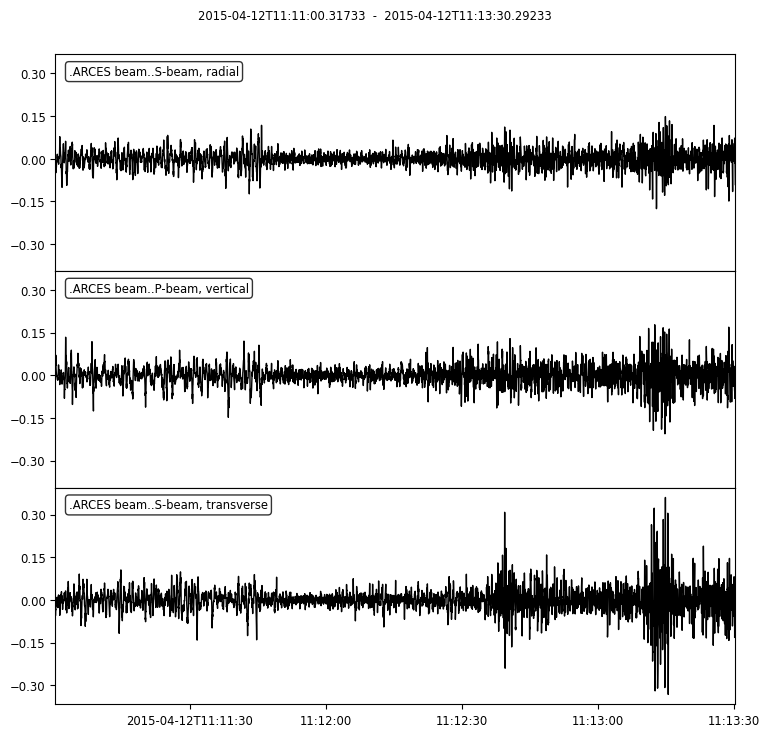

In [15]:
plot_event(trace, info)

In [ ]:
pprint.pprint(no_info)

In [ ]:
shift_trace, shift_info = shift_event(broken_eq)
print(shift_trace.shape)
plot_event(shift_trace, shift_info)

In [ ]:
initial_index, trace, info = find_initial_event_index(broken_eq)
print(initial_index)
pprint.pprint(info)
start_time = parser.isoparse(info['trace_stats']['starttime']).replace(tzinfo=None)
event_time = parser.isoparse(info['est_arrivaltime_arces']).replace(tzinfo=None)

relative_event_time = event_time - start_time
relative_seconds = relative_event_time.total_seconds()
initial_index = math.floor(relative_seconds*sampling_rate)
print(initial_index)

In [ ]:
trace, info = handler.path_to_trace(some_eq)

In [14]:
def plot_event(trace, info):
    start_time = info['origins'][0]['time']
    channels = info['trace_stats']['channels']
    sampl_rate = info['trace_stats']['sampling_rate']
    station = info['trace_stats']['station']
    
    trace_BHE = Trace(
    data=trace[0],
    header={
        'station': station,
        'channel': channels[0],
        'sampling_rate': sampl_rate,
        'starttime': start_time})
    trace_BHN = Trace(
        data=trace[1],
        header={
            'station': station,
            'channel': channels[1],
            'sampling_rate': sampl_rate, 
            'starttime': start_time})
    trace_BHZ = Trace(
        data=trace[2],
        header={
            'station': station,
            'channel': channels[2],
            'sampling_rate': sampl_rate,
            'starttime': start_time})
    stream = Stream([trace_BHE, trace_BHN, trace_BHZ])
    stream.plot()

In [ ]:
eq_trace, eq_info = handler.path_to_trace(broken_eq)
plot_event(eq_trace, eq_info)

In [ ]:
from dateutil import parser
#pprint.pprint(eq_info)

start_time = parser.isoparse(eq_info['origins'][0]['time']).replace(tzinfo=None)
print(start_time)
event_time = parser.isoparse(eq_info['est_arrivaltime_arces'])
print(event_time)
sampling_rate = eq_info['trace_stats']['sampling_rate']

relative_event_time = event_time - start_time
relative_seconds = relative_event_time.total_seconds()
initial_index = relative_seconds*sampling_rate
print(initial_index)

{'analyst_pick_time': None,
 'az_to_arces': 41.29157761552466,
 'baz_to_arces': 242.79234883014138,
 'dist_to_arces': 1361.1977383995043,
 'est_arrivaltime_arces': '2015-07-11 01:41:33.470000',
 'event_type': 'earthquake',
 'event_type_certainty': 'known',
 'magnitude_dist_ratio': 0.0016536906699879804,
 'magnitude_sqrtdist_ratio': 0.06101194717547493,
 'magnitudes': [{'mag': 2.251,
                 'magnitude_type': 'Mb',
                 'origin_id': 'smi:local/b6237688-ee4d-44b5-8391-aab180d33332',
                 'resource_id': 'smi:local/f08083f1-46d9-46a6-b8b3-35887f2ec6c8'},
                {'mag': 1.5,
                 'magnitude_type': 'Ml',
                 'origin_id': 'smi:local/b6237688-ee4d-44b5-8391-aab180d33332',
                 'resource_id': 'smi:local/1508237c-eaaf-4960-a436-983d144f2d9f'}],
 'origins': [{'arrivals': [{'azimuth': 264.66301,
                            'backazimuth_residual': -999.0,
                            'comments': [{'resource_id': 'smi:local/7ac38599-9ba0-4e0c-aea4-2290b48d30cb',
                                          'text': 'ARID=51420'}],
                            'horizontal_slowness_residual': -999.0,
                            'phase': 'Sn',
                            'pick_id': 'smi:local/d94f53b6-fd78-4cb1-b667-ccfb9707a7f5',
                            'resource_id': 'smi:local/c6c341ab-4e1d-4a9d-9c96-984b42494173',
                            'time_residual': -1.8494183},
                           {'azimuth': 282.0618,
                            'backazimuth_residual': -999.0,
                            'comments': [{'resource_id': 'smi:local/ff495e37-8457-465f-ad71-fe3e77104707',
                                          'text': 'ARID=51421'}],
                            'horizontal_slowness_residual': -999.0,
                            'phase': 'Lg',
                            'pick_id': 'smi:local/82afdaf6-d6bc-4714-a4ff-354414093e48',
                            'resource_id': 'smi:local/bb7a84e7-0564-4b21-8478-16c4832466a9',
                            'time_residual': 1.1276108},
                           {'azimuth': 282.0618,
                            'backazimuth_residual': -999.0,
                            'comments': [{'resource_id': 'smi:local/a302aaf7-9011-476d-a23c-edbb4e8a5b5c',
                                          'text': 'ARID=51422'}],
                            'horizontal_slowness_residual': -999.0,
                            'phase': 'Pn',
                            'pick_id': 'smi:local/07debc07-cd08-4b21-b13a-16dcfd1da725',
                            'resource_id': 'smi:local/62eb3b10-9c50-4dfe-b02a-8f2ff0363214',
                            'time_residual': 0.25156139},
                           {'azimuth': 284.69384,
                            'backazimuth_residual': -999.0,
                            'comments': [{'resource_id': 'smi:local/66f2c26b-6702-4017-a5f8-ceb39a04614e',
                                          'text': 'ARID=51423'}],
                            'horizontal_slowness_residual': -999.0,
                            'phase': 'Lg',
                            'pick_id': 'smi:local/ecbb394d-9bda-4e33-b376-5bf8f34c832c',
                            'resource_id': 'smi:local/15cf1963-8d4e-4c38-b10c-2c0a7ece25c4',
                            'time_residual': -5.8988919},
                           {'azimuth': 292.078,
                            'backazimuth_residual': -7.9011668,
                            'comments': [{'resource_id': 'smi:local/4df857e9-6dbe-4a3e-a83a-5670f0cb5996',
                                          'text': 'ARID=51424'}],
                            'horizontal_slowness_residual': -2.9234867,
                            'phase': 'Pn',
                            'pick_id': 'smi:local/6cfd16e9-84df-4550-8c73-f32ae3491857',
                            'resource_id': 'smi:local/f8265085-af25-4a1e-9fbb-71fabf376b5f',
                            'time_residual': 1.6930018},
                           {'azimuth': 288.05724,
                            'backazimuth_residual': 6.9927645,
                            'comments': [{'resource_id': 'smi:local/7fc66aa8-846d-4762-bbcb-f375e85a80ff',
                                          'text': 'ARID=5058921'}],
                            'horizontal_slowness_residual': -2.034051,
                            'phase': 'Pn',
                            'pick_id': 'smi:local/cff348ea-3317-4d75-a250-0e8b1849ce64',
                            'resource_id': 'smi:local/0f937e25-7e3d-4875-8614-6fd9b695e353',
                            'time_residual': -1.915003},
                           {'azimuth': 288.05724,
                            'backazimuth_residual': 6.7627645,
                            'comments': [{'resource_id': 'smi:local/834fd3c3-b535-4ead-a9d9-142df3281a34',
                                          'text': 'ARID=5058927'}],
                            'horizontal_slowness_residual': -4.6857037,
                            'phase': 'Sn',
                            'pick_id': 'smi:local/dad73d32-4ede-41c7-ab7f-d2e3ab2fe7f3',
                            'resource_id': 'smi:local/3fc34832-7f0d-43de-b4ea-7e56e79c15ae',
                            'time_residual': -2.5075625},
                           {'azimuth': 292.078,
                            'backazimuth_residual': 4.4870482,
                            'comments': [{'resource_id': 'smi:local/691a9f56-f432-44aa-890c-a8655d5aa1c2',
                                          'text': 'ARID=5058929'}],
                            'horizontal_slowness_residual': -2.9264298,
                            'phase': 'Sn',
                            'pick_id': 'smi:local/d56bdfa0-6279-47b8-a3cb-7dc87dcc6c0c',
                            'resource_id': 'smi:local/b1d9dbaa-022b-4e71-b19e-dfa7c06709a3',
                            'time_residual': 1.001216},
                           {'azimuth': 284.69384,
                            'backazimuth_residual': 1.2061596,
                            'comments': [{'resource_id': 'smi:local/73ada222-ba66-48ba-a785-8a6583de6099',
                                          'text': 'ARID=10127282'}],
                            'horizontal_slowness_residual': -0.81531174,
                            'phase': 'Pn',
                            'pick_id': 'smi:local/eaf9d35d-8ba4-40fd-8705-1f6b63437fdf',
                            'resource_id': 'smi:local/373414b5-6913-4289-8ea8-467e5ab77843',
                            'time_residual': -0.21510253},
                           {'azimuth': 284.69384,
                            'backazimuth_residual': 1.0061596,
                            'comments': [{'resource_id': 'smi:local/9b1335dc-8aec-486b-9465-43c842f4de66',
                                          'text': 'ARID=10127283'}],
                            'horizontal_slowness_residual': 0.56019928,
                            'phase': 'Sn',
                            'pick_id': 'smi:local/eff7d55f-b22c-45e7-92d0-01c28a0f7057',
                            'resource_id': 'smi:local/615bbab1-0b7b-4f11-a647-7674f7979815',
                            'time_residual': -1.3685685},
                           {'azimuth': 40.515957,
                            'backazimuth_residual': -999.0,
                            'comments': [{'resource_id': 'smi:local/40f0d608-238a-4e8a-9fe2-732ffe51fb84',
                                          'text': 'ARID=51416'}],
                            'horizontal_slowness_residual': -999.0,
                            'phase': 'Sn',
                            'pick_id': 'smi:local/6c08b2e3-cd1f-400b-8095-3e0aa4175dea',
                            'resource_id': 'smi:local/95f8c1f5-385d-478a-bcf8-095486341c8d',
                            'time_residual': -2.1312188},
                           {'azimuth': 40.515957,
                            'backazimuth_residual': -999.0,
                            'comments': [{'resource_id': 'smi:local/806ef43b-c39d-4aa7-b9de-8b6cbe98c3e7',
                                          'text': 'ARID=51417'}],
                            'horizontal_slowness_residual': -999.0,
                            'phase': 'Pn',
                            'pick_id': 'smi:local/8ff5e958-ea0f-4faa-b7a4-c2cbadf082be',
                            'resource_id': 'smi:local/bd705fc0-e532-42bd-8679-7028c10823ca',
                            'time_residual': -0.37866468},
                           {'azimuth': 291.30956,
                            'backazimuth_residual': -999.0,
                            'comments': [{'resource_id': 'smi:local/ca39da24-9dfe-40d1-82ac-ac5bfa0e6204',
                                          'text': 'ARID=51418'}],
                            'horizontal_slowness_residual': -999.0,
                            'phase': 'Sn',
                            'pick_id': 'smi:local/5824c4b2-8301-49b3-bd1a-1ce4c5b2ac68',
                            'resource_id': 'smi:local/c4b47394-8454-4d4a-982d-3ba35befe6b3',
                            'time_residual': 1.046918},
                           {'azimuth': 291.30956,
                            'backazimuth_residual': -999.0,
                            'comments': [{'resource_id': 'smi:local/17a767f9-9038-47f8-a1a0-5a89be4d0cfd',
                                          'text': 'ARID=51419'}],
                            'horizontal_slowness_residual': -999.0,
                            'phase': 'Pn',
                            'pick_id': 'smi:local/8039d945-a7d6-46a1-9fda-a38979441c28',
                            'resource_id': 'smi:local/6513e828-e166-426f-945e-3d90822ef121',
                            'time_residual': 1.2761877}],
              'comments': [{'resource_id': 'smi:local/32ee4897-2203-4182-b36f-dd11d8cfd4e9',
                            'text': 'orid: 18827'}],
              'creation_info': {'agency_id': 'NORSAR',
                                'author': 'ARS:berit',
                                'creation_time': '2015-08-10T12:23:51.000000Z'},
              'depth': 6.8413744,
              'depth_errors': {'uncertainty': 22.255111},
              'latitude': 61.869417,
              'longitude': 2.026115,
              'quality': {'associated_phase_count': 14, 'used_phase_count': 14},
              'resource_id': 'smi:local/b6237688-ee4d-44b5-8391-aab180d33332',
              'time': '2015-07-11T01:38:04.055310Z',
              'time_errors': {'uncertainty': 5.1670545}}],
 'resource_id': 'smi:local/a73ab6ac-291e-4a98-91a6-e39e9309673e',
 'trace_stats': {'channels': ['P-beam, vertical',
                              'S-beam, transverse',
                              'S-beam, radial'],
                 'sampling_rate': 40.0,
                 'starttime': '2015-07-11T01:40:33.475000Z',
                 'station': 'ARCES beam'}}

 - Which time should i look at?
 - The time uncertainty is in seconds, right?
 - How long does earthquakes recorded by ARCES normally last?
 - Some uncertainties are so high that the event could have occured prior to recording. For events such as this I assume that the event starts at index = 0.
 - Some events lack uncertainty measure.
 - What does est_arrivaltime_arces actually mean? Assumed it meant event_start_time but then I saw noise has the same statistic.
 - Can I use noise augmentation when training a model which does not classify noise?
 - How do I draw vertical lines in Obspy?

In [ ]:
"""
     Likely depreciated due to new fitting method.
         
    def find_initial_event_index(self, path):
        trace, info = self.handler.path_to_trace(path)
        start_time = parser.isoparse(info['trace_stats']['starttime']).replace(tzinfo=None)
        if info['analyst_pick_time'] != None:
            event_time = parser.isoparse(info['analyst_pick_time']).replace(tzinfo=None)
        else:
            event_time = parser.isoparse(info['est_arrivaltime_arces']).replace(tzinfo=None)
        sampling_rate = info['trace_stats']['sampling_rate']
        relative_seconds = (event_time - start_time).total_seconds()
        # Problem with uncertainty: Some events have very large uncertainty.
        # This can be so high that the interesting event could have potentially occured prior to the recording.
        if 'time_errors' in info['origins'][0]:
            uncertainty = float(info['origins'][0]['time_errors']['uncertainty'])
        else:
            uncertainty = 0
        initial_index = max(math.floor((relative_seconds-uncertainty)*sampling_rate),0)

        return initial_index, trace, info

    def shift_event(self, path):
        initial_index, trace, info = self.find_initial_event_index(path)
        pre_length = trace.shape[1]
        random_start_index = np.random.randint(0, 5000)
        augmented_trace = np.empty((3, 6000))
        interesting_part_length = pre_length - initial_index
        # Handling what happens when the duration of the interesting event is shorter than what is needed to fill the array:
        ideal_length = augmented_trace.shape[1] - random_start_index
        missing_length = ideal_length - interesting_part_length
        if missing_length > 0:
            filler_index_start = np.random.randint(0, (initial_index - missing_length))
            filler_index_end = filler_index_start + missing_length
            # First index of what requires more filling
            required_fill_index_start = augmented_trace.shape[1] - missing_length

        for i in range(augmented_trace.shape[0]):
            augmented_trace[i][0:random_start_index] = trace[i][0:random_start_index]
            augmented_trace[i][random_start_index:random_start_index + interesting_part_length] = trace[i][initial_index: initial_index + (augmented_trace.shape[1] - random_start_index)]
            if missing_length > 0:
                augmented_trace[i][required_fill_index_start:augmented_trace.shape[1]] = trace[i][filler_index_start:filler_index_end]

        return augmented_trace
"""

In [ ]:
a = [1,1,1,1,1,1]
b = [2,2,2]
a[0:len(b)] = b
a